https://zenodo.org/records/7395397

https://www.biorxiv.org/content/10.1101/2023.04.26.538471v1.full

# Set-up

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Change working dir
os.chdir("/cellar/users/aklie/data/datasets/deBoer_random-promoters_GPRA/")

# Load data

## Load sequences

In [3]:
# Read tabular
train_valid = pd.read_table("dataset_preparation/2023_12_22/dream/train_sequences.txt", header=None, sep="\t")
train_valid.columns = ["seq", "bin"]
print(len(train_valid))
train_valid.head()

6739258


,seq,bin
0,TGCATTTTTTTCACATCTCTTTGCCACGGGGTGAAGGATAGGATGG...,11.0
1,TGCATTTTTTTCACATCTATGTTGCGTTAGAACGATATTGGAACAC...,6.0
2,TGCATTTTTTTCACATCTGTGAAGAATATCAGCTTTCAATCGTATT...,8.0
3,TGCATTTTTTTCACATCAATCCGAGATATCTGTTGATAAACTTACC...,9.0
4,TGCATTTTTTTCACATCAAGTTATCTGGTGTACGTTTTCTCGTATA...,12.0


## Create fold split

In [4]:
import mmh3


def hash_fun(seq, seed):
    return mmh3.hash(seq, seed, signed=False) % 10

In [5]:
# Create fold split
fold = list(map(lambda x: hash_fun(x, 1234), train_valid.seq))
train_valid['fold'] = fold
train_valid = train_valid.sort_values('fold')
train_valid["fold"].value_counts()

7    674870
3    674634
0    674598
6    674300
8    674223
1    674008
2    673957
5    673238
4    672990
9    672440
Name: fold, dtype: int64

## Preprocess sequences

In [6]:
LEFT_ADAPTER = "TGCATTTTTTTCACATC" 
RIGHT_ADAPTER = "GGTTACGGCTGTT"

PLASMID = "aactctcaaggatcttaccgctgttgagatccagttcgatgtaacccactcgtgcacccaactgatcttcagcatcttttactttcaccagcgtttctgggtgagcaaaaacaggaaggcaaaatgccgcaaaaaagggaataagggcgacacggaaatgttgaatactcatactcttcctttttcaatattattgaagcatttatcagggttattgtctcatgagcggatacatatttgaatgtatttagaaaaataaacaaataggggttccgcgcacatttccccgaaaagtgccacctgacgtcatctatattaccctgttatccctagcggatctgccggtagaggtgtggtcaataagagcgacctcatactatacctgagaaagcaacctgacctacaggaaagagttactcaagaataagaattttcgttttaaaacctaagagtcactttaaaatttgtatacacttattttttttataacttatttaataataaaaatcataaatcataagaaattcgcttatttagaagtGGCGCGCCGGTCCGttacttgtacagctcgtccatgccgccggtggagtggcggccctcggcgcgttcgtactgttccacgatggtgtagtcctcgttgtgggaggtgatgtccaacttgatgttgacgttgtaggcgccgggcagctgcacgggcttcttggccttgtaggtggtcttgacctcagcgtcgtagtggccgccgtccttcagcttcagcctctgcttgatctcgcccttcagggcgccgtcctcggggtacatccgctcggaggaggcctcccagcccatggtcttcttctgcattacggggccgtcggaggggaagttggtgccgcgcagcttcaccttgtagatgaactcgccgtcctgcagggaggagtcctgggtcacggtcaccacgccgccgtcctcgaagttcatcacgcgctcccacttgaagccctcggggaaggacagcttcaagtagtcggggatgtcggcggggtgcttcacgtaggccttggagccgtacatgaactgaggggacaggatgtcccaggcgaagggcagggggccacccttggtcaccttcagcttggcggtctgggtgccctcgtaggggcggccctcgccctcgccctcgatctcgaactcgtggccgttcacggagccctccatgtgcaccttgaagcgcatgaactccttgatgatggccatgttatcctcctcgcccttgctcacCATGGTACTAGTGTTTAGTTAATTATAGTTCGTTGACCGTATATTCTAAAAACAAGTACTCCTTAAAAAAAAACCTTGAAGGGAATAAACAAGTAGAATAGATAGAGAGAAAAATAGAAAATGCAAGAGAATTTATATATTAGAAAGAGAGAAAGAAAAATGGAAAAAAAAAAATAGGAAAAGCCAGAAATAGCACTAGAAGGAGCGACACCAGAAAAGAAGGTGATGGAACCAATTTAGCTATATATAGTTAACTACCGGCTCGATCATCTCTGCCTCCAGCATAGTCGAAGAAGAATTTTTTTTTTCTTGAGGCTTCTGTCAGCAACTCGTATTTTTTCTTTCTTTTTTGGTGAGCCTAAAAAGTTCCCACGTTCTCTTGTACGACGCCGTCACAAACAACCTTATGGGTAATTTGTCGCGGTCTGGGTGTATAAATGTGTGGGTGCAACATGAATGTACGGAGGTAGTTTGCTGATTGGCGGTCTATAGATACCTTGGTTATGGCGCCCTCACAGCCGGCAGGGGAAGCGCCTACGCTTGACATCTACTATATGTAAGTATACGGCCCCATATATAggccctttcgtctcgcgcgtttcggtgatgacggtgaaaacctctgacacatgcagctcccggagacggtcacagcttgtctgtaagcggatgccgggagcagacaagcccgtcagggcgcgtcagcgggtgttggcgggtgtcggggctggcttaactatgcggcatcagagcagattgtactgagagtgcaccatatggacatattgtcgttagaacgcggctacaattaatacataaccttatgtatcatacacatacgatttaggtgacactatagaacgcggccgccagctgaagctttaactatgcggcatcagagcagattgtactgagagtgcaccataccaccttttcaattcatcattttttttttattcttttttttgatttcggtttccttgaaatttttttgattcggtaatctccgaacagaaggaagaacgaaggaaggagcacagacttagattggtatatatacgcatatgtagtgttgaagaaacatgaaattgcccagtattcttaacccaactgcacagaacaaaaacctgcaggaaacgaagataaatcatgtcgaaagctacatataaggaacgtgctgctactcatcctagtcctgttgctgccaagctatttaatatcatgcacgaaaagcaaacaaacttgtgtgcttcattggatgttcgtaccaccaaggaattactggagttagttgaagcattaggtcccaaaatttgtttactaaaaacacatgtggatatcttgactgatttttccatggagggcacagttaagccgctaaaggcattatccgccaagtacaattttttactcttcgaagacagaaaatttgctgacattggtaatacagtcaaattgcagtactctgcgggtgtatacagaatagcagaatgggcagacattacgaatgcacacggtgtggtgggcccaggtattgttagcggtttgaagcaggcggcagaagaagtaacaaaggaacctagaggccttttgatgttagcagaattgtcatgcaagggctccctatctactggagaatatactaagggtactgttgacattgcgaagagcgacaaagattttgttatcggctttattgctcaaagagacatgggtggaagagatgaaggttacgattggttgattatgacacccggtgtgggtttagatgacaagggagacgcattgggtcaacagtatagaaccgtggatgatgtggtctctacaggatctgacattattattgttggaagaggactatttgcaaagggaagggatgctaaggtagagggtgaacgttacagaaaagcaggctgggaagcatatttgagaagatgcggccagcaaaactaaaaaactgtattataagtaaatgcatgtatactaaactcacaaattagagcttcaatttaattatatcagttattaccctatgcggtgtgaaataccgcacagatgcgtaaggagaaaataccgcatcaggaaattgtaagcgttaatattttgttaaaattcgcgttaaatttttgttaaatcagctcattttttaaccaataggccgaaatcggcaaaatcccttataaatcaaaagaatagaccgagatagggttgagtgttgttccagtttggaacaagagtccactattaaagaacgtggactccaacgtcaaagggcgaaaaaccgtctatcagggcgatggcccactacgtgaaccatcaccctaatcaagtGCTAGCAGGAATGATGCAAAAGGTTCCCGATTCGAACTGCATTTTTTTCACATCNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGGTTACGGCTGTTTCTTAATTAAAAAAAGATAGAAAACATTAGGAGTGTAACACAAGACTTTCGGATCCTGAGCAGGCAAGATAAACGAAGGCAAAGatgtctaaaggtgaagaattattcactggtgttgtcccaattttggttgaattagatggtgatgttaatggtcacaaattttctgtctccggtgaaggtgaaggtgatgctacttacggtaaattgaccttaaaattgatttgtactactggtaaattgccagttccatggccaaccttagtcactactttaggttatggtttgcaatgttttgctagatacccagatcatatgaaacaacatgactttttcaagtctgccatgccagaaggttatgttcaagaaagaactatttttttcaaagatgacggtaactacaagaccagagctgaagtcaagtttgaaggtgataccttagttaatagaatcgaattaaaaggtattgattttaaagaagatggtaacattttaggtcacaaattggaatacaactataactctcacaatgtttacatcactgctgacaaacaaaagaatggtatcaaagctaacttcaaaattagacacaacattgaagatggtggtgttcaattagctgaccattatcaacaaaatactccaattggtgatggtccagtcttgttaccagacaaccattacttatcctatcaatctgccttatccaaagatccaaacgaaaagagagaccacatggtcttgttagaatttgttactgctgctggtattacccatggtatggatgaattgtacaaataaggcgcgccacttctaaataagcgaatttcttatgatttatgatttttattattaaataagttataaaaaaaataagtgtatacaaattttaaagtgactcttaggttttaaaacgaaaattcttattcttgagtaactctttcctgtaggtcaggttgctttctcaggtatagtatgaggtcgctcttattgaccacacctctaccggcagatccgctagggataacagggtaatataGATCTGTTTAGCTTGCCTCGTCCCCGCCGGGTCACCCGGCCAGCGACATGGAGGCCCAGAATACCCTCCTTGACAGTCTTGACGTGCGCAGCTCAGGGGCATGATGTGACTGTCGCCCGTACATTTAGCCCATACATCCCCATGTATAATCATTTGCATCCATACATTTTGATGGCCGCACGGCGCGAAGCAAAAATTACGGCTCCTCGCTGCAGACCTGCGAGCAGGGAAACGCTCCCCTCACAGACGCGTTGAATTGTCCCCACGCCGCGCCCCTGTAGAGAAATATAAAAGGTTAGGATTTGCCACTGAGGTTCTTCTTTCATATACTTCCTTTTAAAATCTTGCTAGGATACAGTTCTCACATCACATCCGAACATAAACAACCATGGGTACCACTCTTGACGACACGGCTTACCGGTACCGCACCAGTGTCCCGGGGGACGCCGAGGCCATCGAGGCACTGGATGGGTCCTTCACCACCGACACCGTCTTCCGCGTCACCGCCACCGGGGACGGCTTCACCCTGCGGGAGGTGCCGGTGGACCCGCCCCTGACCAAGGTGTTCCCCGACGACGAATCGGACGACGAATCGGACGACGGGGAGGACGGCGACCCGGACTCCCGGACGTTCGTCGCGTACGGGGACGACGGCGACCTGGCGGGCTTCGTGGTCGTCTCGTACTCCGGCTGGAACCGCCGGCTGACCGTCGAGGACATCGAGGTCGCCCCGGAGCACCGGGGGCACGGGGTCGGGCGCGCGTTGATGGGGCTCGCGACGGAGTTCGCCCGCGAGCGGGGCGCCGGGCACCTCTGGCTGGAGGTCACCAACGTCAACGCACCGGCGATCCACGCGTACCGGCGGATGGGGTTCACCCTCTGCGGCCTGGACACCGCCCTGTACGACGGCACCGCCTCGGACGGCGAGCAGGCGCTCTACATGAGCATGCCCTGCCCCTAATCAGTACTGACAATAAAAAGATTCTTGTTTTCAAGAACTTGTCATTTGTATAGTTTTTTTATATTGTAGTTGTTCTATTTTAATCAAATGTTAGCGTGATTTATATTTTTTTTCGCCTCGACATCATCTGCCCAGATGCGAAGTTAAGTGCGCAGAAAGTAATATCATGCGTCAATCGTATGTGAATGCTGGTCGCTATACTGCTGTCGATTCGATACTAACGCCGCCATCCAGTGTCGAAAACGAGCTCGaattcctgggtccttttcatcacgtgctataaaaataattataatttaaattttttaatataaatatataaattaaaaatagaaagtaaaaaaagaaattaaagaaaaaatagtttttgttttccgaagatgtaaaagactctagggggatcgccaacaaatactaccttttatcttgctcttcctgctctcaggtattaatgccgaattgtttcatcttgtctgtgtagaagaccacacacgaaaatcctgtgattttacattttacttatcgttaatcgaatgtatatctatttaatctgcttttcttgtctaataaatatatatgtaaagtacgctttttgttgaaattttttaaacctttgtttatttttttttcttcattccgtaactcttctaccttctttatttactttctaaaatccaaatacaaaacataaaaataaataaacacagagtaaattcccaaattattccatcattaaaagatacgaggcgcgtgtaagttacaggcaagcgatccgtccGATATCatcagatccactagtggcctatgcggccgcggatctgccggtctccctatagtgagtcgtattaatttcgataagccaggttaacctgcattaatgaatcggccaacgcgcggggagaggcggtttgcgtattgggcgctcttccgcttcctcgctcactgactcgctgcgctcggtcgttcggctgcggcgagcggtatcagctcactcaaaggcggtaatacggttatccacagaatcaggggataacgcaggaaagaacatgtgagcaaaaggccagcaaaaggccaggaaccgtaaaaaggccgcgttgctggcgtttttccataggctccgcccccctgacgagcatcacaaaaatcgacgctcaagtcagaggtggcgaaacccgacaggactataaagataccaggcgtttccccctggaagctccctcgtgcgctctcctgttccgaccctgccgcttaccggatacctgtccgcctttctcccttcgggaagcgtggcgctttctcaTAgctcacgctgtaggtatctcagttcggtgtaggtcgttcgctccaagctgggctgtgtgcacgaaccccccgttcagcccgaccgctgcgccttatccggtaactatcgtcttgagtccaacccggtaagacacgacttatcgccactggcagcagccactggtaacaggattagcagagcgaggtatgtaggcggtgctacagagttcttgaagtggtggcctaactacggctacactagaagAacagtatttggtatctgcgctctgctgaagccagttaccttcggaaaaagagttggtagctcttgatccggcaaacaaaccaccgctggtagcggtggtttttttgtttgcaagcagcagattacgcgcagaaaaaaaggatctcaagaagatcctttgatcttttctacggggtctgacgctcagtggaacgaaaactcacgttaagggattttggtcatgagattatcaaaaaggatcttcacctagatccttttaaattaaaaatgaagttttaaatcaatctaaagtatatatgagtaaacttggtctgacagttaccaatgcttaatcagtgaggcacctatctcagcgatctgtctatttcgttcatccatagttgcctgactccccgtcgtgtagataactacgatacgggagggcttaccatctggccccagtgctgcaatgataccgcgagacccacgTtcaccggctccagatttatcagcaataaaccagccagccggaagggccgagcgcagaagtggtcctgcaactttatccgcctccatccagtctattaattgttgccgggaagctagagtaagtagttcgccagttaatagtttgcgcaacgttgttgccattgctacaggcatcgtggtgtcacgctcgtcgtttggtatggcttcattcagctccggttcccaacgatcaaggcgagttacatgatcccccatgttgtgcaaaaaagcggttagctccttcggtcctccgatcgttgtcagaagtaagttggccgcagtgttatcactcatggttatggcagcactgcataattctcttactgtcatgccatccgtaagatgcttttctgtgactggtgagtactcaaccaagtcattctgagaatagtgtatgcggcgaccgagttgctcttgcccggcgtcaatacgggataataccgcgccacatagcagaactttaaaagtgctcatcattggaaaacgttcttcggggcgaa"
PLASMID = PLASMID.upper()
INSERT_START = PLASMID.find('N'*80)


def preprocess_data(data, length):
    data = data.copy()
    add_part = PLASMID[INSERT_START-length:INSERT_START]
    data.seq = data.seq.apply(lambda x:  add_part + x[len(LEFT_ADAPTER):])
    data.seq = data.seq.str.slice(-length, None)
    return data

In [7]:
train_valid = preprocess_data(train_valid, 150)
train_valid.head()

,seq,bin,fold
4288439,AGTGCTAGCAGGAATGATGCAAAAGGTTCCCGATTCGAACTGCATT...,11.000000,0
5319238,AGTGCTAGCAGGAATGATGCAAAAGGTTCCCGATTCGAACTGCATT...,14.000000,0
672928,AAGTGCTAGCAGGAATGATGCAAAAGGTTCCCGATTCGAACTGCAT...,7.090078,0
672929,AGTGCTAGCAGGAATGATGCAAAAGGTTCCCGATTCGAACTGCATT...,12.000000,0
2485732,AGTGCTAGCAGGAATGATGCAAAAGGTTCCCGATTCGAACTGCATT...,14.000000,0


## Add singleton column

In [8]:
def infer_singleton(arr, method):
    if method == "integer":
        return np.array([x.is_integer() for x in arr])
    elif method.startswith("threshold"):
        th = float(method.replace("threshold", ""))
        cnt = Counter(arr)
        return np.array([cnt[x] >= th for x in arr])
    else:
        raise Exception("Wrong method")

        
def add_singleton_column(df, method):
    df = df.copy()
    df["is_singleton"] = infer_singleton(df.bin.values,method)
    return df 

In [9]:
train_valid = add_singleton_column(train_valid, "integer")

## Add reverse complement

In [10]:
CODES = {
    "A": 0,
    "T": 3,
    "G": 1,
    "C": 2,
    'N': 4
}

INV_CODES = {value: key for key, value in CODES.items()}

COMPL = {
    'A': 'T',
    'T': 'A',
    'G': 'C',
    'C': 'G',
    'N': 'N'
}


def revcomp(seq):
    return "".join((n2compl(x) for x in reversed(seq)))

def n2id(n):
    return CODES[n.upper()]

def id2n(i):
    return INV_CODES[i]

def n2compl(n):
    return COMPL[n.upper()]

def add_rev(df):
    df = df.copy()
    revdf = df.copy()
    revdf['seq'] = df.seq.apply(revcomp)
    df['rev'] = 0
    revdf['rev'] = 1
    df = pd.concat([df, revdf]).reset_index(drop=True)
    return df

In [11]:
train_valid = add_rev(train_valid)

## Train/val split

In [12]:
train = train_valid[train_valid['fold'] != 9]
valid = train_valid[train_valid['fold'] == 9]

## Dataset Class

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import scipy


class Seq2Tensor(nn.Module):
    '''
    Encode sequences using one-hot encoding after preprocessing.
    '''
    def __init__(self):
        super().__init__()

    def forward(self, seq: str) -> torch.Tensor:
        seq_i = [n2id(x) for x in seq]
        code = torch.from_numpy(np.array(seq_i))
        code = F.one_hot(code, num_classes=5) # 5th class is N

        code = code[:, :5].float()
        code[code[:, 4] == 1] = 0.25 # encode Ns with .25
        code =  code[:, :4]
        return code.transpose(0, 1)


POINTS = np.array([-np.inf, *range(1, 18, 1), np.inf])
class SeqDatasetProb(Dataset):
    
    """ Sequence dataset. """
    
    def __init__(self, ds, seqsize, use_single_channel, use_reverse_channel, use_multisubstate_channel, shift=0.5, scale=0.5):
        """
        Parameters
        ----------
        ds : pd.DataFrame
            Training dataset.
        seqsize : int
            Constant sequence length.
        use_single_channel : bool
            If True, additional binary channel with singleton information is used.
        use_reverse_channel : bool
            If True, additional reverse augmentation is used.
        use_multisubstate_channel : bool
            If True, additional substrate channel is used.
        shift : float, optional
            Assumed sd of real expression normal distribution.
        scale : float, optional
            Assumed scale of real expression normal distribution.
        """
        self.ds = ds
        self.seqsize = seqsize
        self.totensor = Seq2Tensor() 
        self.shift = shift 
        self.scale = scale
        self.use_single_channel = use_single_channel
        self.use_reverse_channel = use_reverse_channel
        self.use_multisubstate_channel = use_multisubstate_channel
        
    def transform(self, x):
        assert isinstance(x, str)
        assert len(x) == self.seqsize
        return self.totensor(x)
    
    def __getitem__(self, i):
        """
        Output
        ----------
        X: torch.Tensor    
            Create one-hot encoding tensor with reverse and singleton channels if required.
        probs: np.ndarray
            Given a measured expression, we assume that the real expression is normally distributed
            with mean=`bin` and sd=`shift`. 
            Resulting `probs` vector contains probabilities that correspond to each class (bin).     
        bin: float 
            Training expression value
        """
        seq = self.transform(self.ds.seq.values[i])
        to_concat = [seq]
        
        # add reverse augmentation channel
        if self.use_reverse_channel:
            rev = torch.full( (1, self.seqsize), self.ds.rev.values[i], dtype=torch.float32)
            to_concat.append(rev)
            
        # add singleton channel
        if self.use_single_channel:
            single = torch.full( (1, self.seqsize) , self.ds.is_singleton.values[i], dtype=torch.float32)
            to_concat.append(single)
            
        # add multiclass channel
        if self.use_multisubstate_channel:
            substrate = torch.full( (1, self.seqsize) , self.ds.substrate.values[i], dtype=torch.float32)
            to_concat.append(substrate)
        
        # create final tensor
        if len(to_concat) > 1:
            X = torch.concat(to_concat, dim=0)
        else:
            X = seq
            
        bin = self.ds.bin.values[i]
        
        # generate probabilities corresponding to each class
        norm = scipy.stats.norm(loc=bin + self.shift, scale=self.scale)
        
        cumprobs = norm.cdf(POINTS)
        probs = cumprobs[1:] - cumprobs[:-1]
        return X, probs, bin
    
    def __len__(self):
        return len(self.ds.seq)
    
    
class DataloaderWrapper:
    def __init__(self, dataloader, batch_per_epoch):
        self.batch_per_epoch = batch_per_epoch
        self.dataloader = dataloader
        self.iterator = iter(dataloader)

    def __len__(self):
        return self.batch_per_epoch
    
    def __next__(self):
        try:
            return next(self.iterator)
        except StopIteration:
            self.iterator = iter(self.dataloader)

    def __iter__(self):
        for _ in range(self.batch_per_epoch):
            try:
                yield next(self.iterator)
            except StopIteration:
                self.iterator = iter(self.dataloader)
                
                
def create_dl(train, valid, 
              seqsize,
              use_single_channel, use_reverse_channel, use_multisubstate_channel,
              train_batch_size, train_workers,
              valid_batch_size, valid_workers,
              batch_per_epoch,
              SeqDatasetProb,
              shuffle_train=True, shuffle_val=False):
    
    train_ds = SeqDatasetProb(train, 
                             seqsize=seqsize, 
                             use_single_channel=use_single_channel,
                             use_reverse_channel=use_reverse_channel,
                             use_multisubstate_channel=use_multisubstate_channel,
                             )

    train_dl = DataLoader(train_ds, 
                          batch_size=train_batch_size,
                          num_workers=train_workers,
                          shuffle=shuffle_train) 

    train_dl = DataloaderWrapper(train_dl, batch_per_epoch)
    
    if valid is None:
        return train_dl, None
    
    valid_ds = SeqDatasetProb(valid, 
                            seqsize=seqsize, 
                            use_single_channel=use_single_channel,
                            use_reverse_channel=use_reverse_channel,
                            use_multisubstate_channel=use_multisubstate_channel
                            )

    valid_dl = DataLoader(valid_ds, 
                        batch_size=valid_batch_size,
                        num_workers=valid_workers,
                        shuffle=shuffle_val) 
    
    return train_dl, valid_dl

In [14]:
train_dl, valid_dl = create_dl(
    train, 
    valid,
    150, 
    True,
    True,
    False,
    128,
    0,
    128,
    0,
    1000,
    SeqDatasetProb,
    True, 
    False
)

In [15]:
batch = next(iter(train_dl))
batch[0].shape, batch[1].shape, batch[2].shape

(torch.Size([128, 6, 150]), torch.Size([128, 18]), torch.Size([128]))

# Model

In [16]:
from legnet import SeqNN

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = SeqNN(
    seqsize=150,
    use_single_channel=True,
    block_sizes=[256, 128, 128, 64, 64, 64, 64],
    ks=7,
    resize_factor=4, 
    se_reduction=4, 
    bn_momentum=0.1,
    final_ch=18
).to(device)

cuda


In [18]:
import math


def initialize_weights(m):
    if isinstance(m, nn.Conv1d):
        n = m.kernel_size[0] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2 / n))
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        m.weight.data.normal_(0, 0.001)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

In [19]:
model.apply(initialize_weights);

In [20]:
criterion = nn.KLDivLoss(reduction= "batchmean").to(device)

In [21]:
X, y_probs, y = next(iter(train_dl))
X = X.to(device)
y_probs = y_probs.float().to(device)
logprobs, y_pred = model(X)

In [22]:
loss = criterion(logprobs, y_probs)
loss

tensor(2.0119, device='cuda:0', grad_fn=<DivBackward0>)

# Training

In [23]:
from pytorch_lightning import LightningModule
from torchmetrics import MeanSquaredError, PearsonCorrCoef, SpearmanCorrCoef
import torch
import json
from pathlib import Path

        
class MyModel(LightningModule):
    def __init__(self, model, criterion, optimizer, scheduler, model_dir, use_validation):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.model_dir = Path(model_dir)
        self.model_dir.mkdir(exist_ok=True, parents=True)
        self.use_validation = use_validation

        #
        self.validation_step_outputs = []
        
        # Metrics
        self.train_mse = MeanSquaredError()
        self.train_pearson = PearsonCorrCoef()
        self.train_spearman = SpearmanCorrCoef()
        self.val_mse = MeanSquaredError()
        self.val_pearson = PearsonCorrCoef()
        self.val_spearman = SpearmanCorrCoef()

    def forward(self, x):
        # Forward pass through the model
        return self.model(x)

    def training_step(self, batch, batch_idx):
        # Unpack data
        X, y_probs, y = batch
        logprobs, y_pred = self(X)  # Forward pass

        # Calculate loss
        loss = self.criterion(logprobs, y_probs)

        # Calculate metrics
        self.train_mse.update(y_pred.detach(), y)
        self.train_pearson.update(y_pred.detach(), y)
        self.train_spearman.update(y_pred.detach(), y)

        # Logging
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_mse', self.train_mse, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_pearson', self.train_pearson, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_spearman', self.train_spearman, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        X, y_probs, y = batch
        logprobs, y_pred = self(X)  # Forward pass
        
        loss = self.criterion(logprobs, y_probs)
        self.validation_step_outputs.append(loss)
        
        # Calculate metrics
        self.val_mse.update(y_pred, y)
        self.val_pearson.update(y_pred, y)
        self.val_spearman.update(y_pred, y)
        

    def on_validation_epoch_end(self):
        # Log validation metrics
        self.log('val_mse', self.val_mse.compute(), prog_bar=True)
        self.log('val_pearson', self.val_pearson.compute(), prog_bar=True)
        self.log('val_spearman', self.val_spearman.compute(), prog_bar=True)

        # Reset metrics
        self.val_mse.reset()
        self.val_pearson.reset()
        self.val_spearman.reset()
        
        # Reset loss
        epoch_average = torch.stack(self.validation_step_outputs).mean()
        self.log("validation_epoch_average", epoch_average)
        self.validation_step_outputs.clear()

    def configure_optimizers(self):
        # Set up optimizers and schedulers
        optimizer = self.optimizer
        scheduler = {
            'scheduler': self.scheduler,
            'interval': 'epoch',
            'frequency': 1
        }
        return [optimizer], [scheduler]

    def on_epoch_end(self):
        # Save models and scores at the end of each epoch
        model_path = self.model_dir / f"model_{self.current_epoch}.pth"
        torch.save(self.model.state_dict(), model_path)

        optimizer_path = self.model_dir / f"optimizer_{self.current_epoch}.pth"
        torch.save(self.optimizer.state_dict(), optimizer_path)

        if self.scheduler is not None:
            scheduler_path = self.model_dir / f"scheduler_{self.current_epoch}.pth"
            torch.save(self.scheduler.state_dict(), scheduler_path)

        if self.use_validation:
            score_path = self.model_dir / f"scores_{self.current_epoch}.json"
            with open(score_path, "w") as outp:
                json.dump(self.trainer.callback_metrics, outp)


In [24]:
def get_optimizer(optimizer_name, model_params, lr, weight_decay):
    if optimizer_name == "adam":
        optimizer = torch.optim.Adam(model_params, lr = lr, weight_decay=weight_decay)
    elif optimizer_name == "adamw":
        optimizer = torch.optim.AdamW(model_params, lr = lr, weight_decay=weight_decay)
    elif optimizer_name == "rmsprop":
        optimizer = torch.optim.RMSprop(model_params, lr = lr, weight_decay=weight_decay)
    else:
        raise Exception("Wrong optimizer")
    return optimizer

optimizer = get_optimizer("adamw", model.parameters(), 0.01, 0.01)

In [25]:
chosen_lr = 10e-2
max_lr, div_factor = chosen_lr, 25.0
min_lr = max_lr / div_factor

In [26]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=max_lr,
    div_factor=div_factor,
    steps_per_epoch=1000, 
    epochs=450, 
    pct_start=0.3,
    three_phase="store_true"
)

In [27]:
def parameter_count(model):
    pars = 0  
    for _, p  in model.named_parameters():    
        pars += torch.prod(torch.tensor(p.shape))
    return pars

In [28]:
print('Model parameters:', int(parameter_count(model)))

Model parameters: 1852846


In [ ]:
from pytorch_lightning import Trainer

# Instantiate the model
model = MyModel(model, criterion, optimizer, scheduler, model_dir="bin/data_exploration/", use_validation=True)

# Set up the trainer
trainer = Trainer(max_epochs=450)  # Set the number of epochs and other parameters as needed

# Train the model
trainer.fit(model, train_dl, valid_dl)  # Provide your DataLoaders here

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWar

Sanity Checking: 0it [00:00, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/ml4gland/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

## SeqData

In [19]:
len(left_adapter), len(right_adapter)

(17, 13)

In [27]:
sdata = xr.Dataset({"seq": xr.DataArray(train_df["seq"].values, dims="_sequence"), 
            "expression_level": xr.DataArray(train_df["expression_level"].values, dims="_sequence")})

In [28]:
import seqpro as sp

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(array([2.500000e+01, 4.422000e+03, 1.455900e+04, 3.206600e+04,
        1.117866e+06, 5.564716e+06, 1.977000e+03, 1.731000e+03,
        1.427000e+03, 4.690000e+02]),
 array([ 78. ,  84.4,  90.8,  97.2, 103.6, 110. , 116.4, 122.8, 129.2,
        135.6, 142. ]),
 <BarContainer object of 10 artists>)

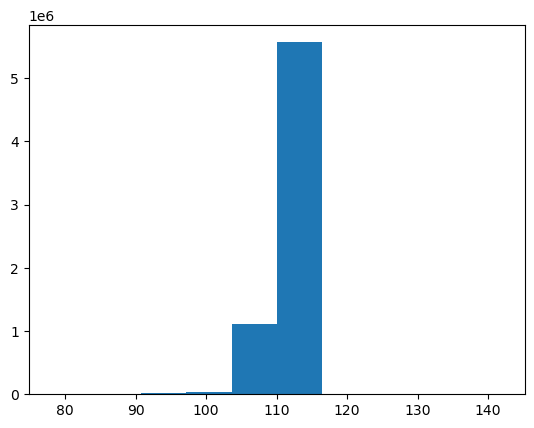

In [34]:
plt.hist(sp.length(sdata["seq"].values))

# DONE!

---